### Functions implemented 

A complete case k-nearest neighbour classifier, returns an estimated label for the test point:
```python
def complete_case_kNN_classifier(x_test, X_train, Y_train, O_train)
```

Two imputation methods can be called, both require only the training data and the observations patterns thereof as inputs, they return an imputed data set of the same size as X_train. The first one imputes with a constant (default is $0$ unless specified otherwise by the user), the second one with the mean of all observed variables.
```python
def constant_impute(X_train, O_train, c=0)
def mean_impute(X_train, O_train)
```

The HAM classifier is implemented, which is given an estimate $\hat{\Omega}$ of (or the true) $\Omega^\star$, and returns an estimated label of the test point. An estimate $\hat{\Omega}$ can be obtained from the training data using the second function:
```python
def HAM_classifier(x_test, Omega_hat, X_train, Y_train, O_train)
def estimate_Omega_star(X_train, Y_train, O_train)
```

The HAM classifier make use of three auxiliary functions:
```python
def transform_j_to_omega(j_omega, d)
def transform_omega_to_j(omega, d)
def all_obs_patterns_of_length(d)
```

In [1]:
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt

d = 5
beta = 1
alpha = 1
gamma = np.ones(2**d)
gamma_max = 1

In [2]:
"""
complete case k-nearest neighbour classifier
"""
        
        
''' Predict value of test point using all available cases '''
def complete_case_kNN_classifier(x_test, X_train, Y_train, O_train):
    mc_distances = []
    mc_y = []
    no_matching_cases = 0
    
    for i in range(N_train):
        if np.all(np.ones(d)<=O_train[i,:]):
            no_matching_cases += 1
            dist = 0
            for j in range(d):
                dist += (x_test[j]-X_train[i,j])**2
            mc_distances.append(np.sqrt(dist))
            mc_y.append(Y_train[i])
            
    sort_index = np.argsort(mc_distances)
    k_mc = int(np.rint(1/3 * no_matching_cases**(beta*gamma_max*(1+alpha)/(gamma_max*(2*beta+d)+alpha*beta))))
    
    if no_matching_cases==0:
        if np.random.uniform()<1/2:
            return 0
        else:
            return 1
    else:
        eta_sum = 0
        for i in range(k_mc):
            eta_sum += 1/k_mc * mc_y[sort_index[i]]

        if eta_sum<1/2:
            return 0
        else:
            return 1

In [3]:
"""
Imputation methods
"""

def constant_impute(X_train, O_train, c=0):
    X_imputed = np.zeros((N_train,d))
    X_imputed += X_train
    if c!=0:
        for it in range(N_train):
            for i in range(d):
                if O_train[it,i]==0:
                    X_imputed[it,i] = c
    return X_imputed

def mean_impute(X_train, O_train):
    X_imputed = np.zeros((N_train,d))
    X_imputed += X_train
    
    means = np.zeros(d)
    for i in range(d):
        means[i] = np.sum(X_train[:,i])/np.sum(O_train[:,i])
    
    for it in range(N_train):
        for i in range(d):
            if O_train[it,i]==0:
                X_imputed[it,i] = means[i]
    return X_imputed

In [4]:
""" 
NB: (0,1,0,0,1,0,1) will be the 0100101_2-th = 37_10-th entry. Can transform by taking 
omega = (omega_1,...,omega_d-1,omega_d) --> corresponding j=omega_d+2*omega_d-1+4*omega_d-2+...+2^(d-1)*omega_1
and also in the other direction
omega_d = j mod2, omega_d-1=((j-omega_d)/2) mod2, omega_d-2 = ((j-omega_d-omega_d-2)/4) mod2, et cetera.
This is implemented in the next two functions.
"""
def transform_j_to_omega(j_omega, d):
    omega=np.zeros(d,dtype="int")
    j=0
    j+=j_omega
    
    for k in range(d):
        omega[d-1-k]=j%2
        j=(j-omega[d-1-k])/2
    return omega

def transform_omega_to_j(omega, d):
    j=0
    for k in range(d):
        j+=omega[d-1-k]*(2**k)
    return j 


''' To create a list with all possible observation patterns we firstly define the following functions '''
def all_obs_patterns_of_length(d):
    pattern_list = []
    omega=np.zeros(d,dtype="int")

    for k in range(d+1):
        pattern_list.append([])
        
    for j in range(2**d):
        omega = transform_j_to_omega(j,d)
        o = int(np.sum(omega))
        pattern_list[o].append(omega)
        
    return pattern_list

    
""" Create a list with all possible observation patterns of length l with o observations (as np arrays), sorted by the number of observed values """
obs_patterns_with_o_observations_and_length_d = []
obs_patterns_with_o_observations_and_length_d.append([])
for l in range(1,d+1):
    obs_patterns_with_o_observations_and_length_d.append(all_obs_patterns_of_length(l))

""" Check that these are the correct observations patterns """    
print(obs_patterns_with_o_observations_and_length_d[3])
print(obs_patterns_with_o_observations_and_length_d[2][1][1])

[[array([0, 0, 0])], [array([0, 0, 1]), array([0, 1, 0]), array([1, 0, 0])], [array([0, 1, 1]), array([1, 0, 1]), array([1, 1, 0])], [array([1, 1, 1])]]
[1 0]


In [5]:
"""
HAM Classifier
"""

''' Predict value of fully observed test point using missing data anova decomposition '''
def HAM_classifier(x_test, Omega_hat, X_train, Y_train, O_train):
    
    # f_0 is the expectation of Y-1/2
    f_hat_0 = sum(Y_train)/len(Y_train) - 1/2
    
    """ Estimate f_omega at test point for each observation pattern """   
    f_hat_omega = np.zeros(2**d)
    f_hat_omega[0] = f_hat_0 
    
    ''' Iterate through the different observation patterns '''
    for o in range(1,d+1):
        l_max = len(obs_patterns_with_o_observations_and_length_d[d][o])
        for omega_d_o in range(l_max):
            
            # get observation pattern, transform to index
            omega = obs_patterns_with_o_observations_and_length_d[d][o][omega_d_o]
            j_omega = transform_omega_to_j(omega,d)
            
            # calculate number of available cases
            N_available = 0
            for it in range(N_train):
                if (omega<=O_train[it,:]).all():
                    N_available += 1
            
            # calculate 
            if N_available>0:
                gamma_omega = 1#np.amax(gamma*omega)
                exponent = beta*gamma_omega/(gamma_omega*(2*beta+sum(omega))+alpha*beta)
                k_omega = 1+int(np.floor(N_available**(2*exponent)))
                        
            # Estimate f_omega at test point
            if N_available>=1:

                # compute distances to test point, only considering the w-observed variables
                distances = []
                for i in range(N_train):
                    if (omega<=O_train[i,:]).all():
                        dist = 0
                        for k in range(d):
                            if omega[k]==1:
                                dist += (x_test[k]-X_train[i,k])**2
                        distances.append(np.sqrt(dist))
                    else:
                        distances.append(100.0) # make sure that unavailable data points are not a nearest neighbour

                # sort distances
                sort_index = np.argsort(distances)

                # add Monte Carlo estimate of eta to f_omega
                for i in range(k_omega):
                    f_hat_omega[j_omega] += 1/k_omega * Y_train[sort_index[i]] 

                # substract 1/2 from the estimate
                f_hat_omega[j_omega] -= 1/2

                # substract Monte Carlo estimates of f_{omega_subset} from f_omega
                omega_subset = np.zeros(d,dtype="int")
                for j_short in range(2**o-1):
                    omega_short = transform_j_to_omega(j_short,o)
                    omega_subset = 0*omega_subset
                    omega_subset[np.nonzero(omega)] = omega_short
                    j_subset = transform_omega_to_j(omega_subset,d)

                    f_hat_omega[j_omega] -= f_hat_omega[j_subset]
  
        
    ''' Estimate eta '''
    eta_test = 1/2
    for o in range(d+1):
        l_max = len(obs_patterns_with_o_observations_and_length_d[d][o])
        for omega_d_o in range(l_max):
            
            # get observation pattern, transform to index
            omega = obs_patterns_with_o_observations_and_length_d[d][o][omega_d_o]
            j_omega = transform_omega_to_j(omega,d)
            
            # check if omega<= element for some element in Omega_hat, return 1 if this is the case
            helpy = 0 
            for elem in Omega_hat:
                if (omega<=elem).all():
                    helpy = 1
                    
            # if intersection is empty, add omega to Omega_hat
            if helpy == 1:
                eta_test += f_hat_omega[j_omega]
                            
    if eta_test<1/2:
        return 0
    else:
        return 1

In [6]:
"""
HAM Classifier - estimates Omega hat and then uses the oracle version
"""

''' Estimate Omega_star using missing data anova decomposition '''
def estimate_Omega_star(X_train, Y_train, O_train):
    
    # Quantities needed for thresholding
    tau_omega = np.ones(2**d)
    sigma_hat_omega_sq = np.zeros(2**d)
    
    # f_0 is the expectation of Y-1/2
    f_hat_0 = sum(Y_train)/len(Y_train) - 1/2
    sigma_hat_omega_sq[0] = f_hat_0**2
    
    """ Estimate f_omega at all training points for each observation pattern """   
    f_hat_omega = np.zeros((N_train,2**d))
    f_hat_omega[:,0] = f_hat_0*np.ones(N_train) 
    
    ''' Iterate through the different observation patterns '''
    for o in range(1,d+1):
        l_max = len(obs_patterns_with_o_observations_and_length_d[d][o])
        for omega_d_o in range(l_max):
            
            # get observation pattern, transform to index
            omega = obs_patterns_with_o_observations_and_length_d[d][o][omega_d_o]
            j_omega = transform_omega_to_j(omega,d)
            
            # calculate number of available cases
            N_available = 0
            for it in range(N_train):
                if (omega<=O_train[it,:]).all():
                    N_available += 1
            
            # calculate 
            if N_available>0:
                gamma_omega = 1#np.amax(gamma*omega)
                exponent = beta*gamma_omega/(gamma_omega*(2*beta+sum(omega))+alpha*beta)
                k_omega = 1+int(np.floor(N_available**(2*exponent)))
                tau_omega[j_omega] = 1/(N_available**exponent)/16
            
            # For all training points that are available cases for the observation pattern
            for it in range(N_train):
                if (omega<=O_train[it,:]).all() and N_available>=1:
            
                    # compute distances to all other training points, only considering the w-observed variables
                    distances = []
                    for i in range(N_train):
                        if (omega<=O_train[i,:]).all():
                            dist = 0
                            for k in range(d):
                                if omega[k]==1:
                                    dist += (X_train[it,k]-X_train[i,k])**2
                            distances.append(np.sqrt(dist))
                        else:
                            distances.append(1000) # make sure that unavailable data points are not a nearest neighbour

                    # sort distances and decide on k_omega and the threshold tau_omega
                    sort_index = np.argsort(distances)

                    # add Monte Carlo estimate of eta to f_omega
                    for i in range(k_omega):
                        f_hat_omega[it,j_omega] += 1/k_omega * Y_train[sort_index[i]] 

                    # substract 1/2 from the estimate
                    f_hat_omega[it,j_omega] -= 1/2

                    # substract Monte Carlo estimates of f_{omega_subset} from f_omega
                    omega_subset = np.zeros(d,dtype="int")
                    for j_short in range(2**o-1):
                        omega_short = transform_j_to_omega(j_short,o)
                        omega_subset = 0*omega_subset
                        omega_subset[np.nonzero(omega)] = omega_short
                        j_subset = transform_omega_to_j(omega_subset,d)

                        f_hat_omega[it,j_omega] -= f_hat_omega[it,j_subset]
                    
            # Calculate Sobol index                   
            if N_available>=1:
                sigma_hat_omega_sq[j_omega] = 1/N_available * np.sum(f_hat_omega[0:N_train,j_omega]**2)     

    """ Estimate Omega_hat """                        
    Omega_hat = []
    Omega_hat_cup_L_Omega_hat = []
    
    ''' Iterate through the different observation patterns, starting from the fully observed one '''
    for d_prime in range(d+1):
        
        l_max = len(obs_patterns_with_o_observations_and_length_d[d][d-d_prime])
        for omega_d_d_prime in range(l_max):
            
            # get observation pattern, transform to index
            omega = obs_patterns_with_o_observations_and_length_d[d][d-d_prime][omega_d_d_prime]
            
            # check if U({omega}) intersect hat_Omega is empty, return 0 if this is the case
            helpy = 0 
            for elem in Omega_hat_cup_L_Omega_hat:
                if (elem==omega).all():
                    helpy = 1
                    
            # if intersection is empty, add omega to Omega_hat and L(omega) to Omega_hat_cup_L_Omega_hat
            if helpy == 0:
                j_omega = transform_omega_to_j(omega,d)
                if sigma_hat_omega_sq[j_omega] >= tau_omega[j_omega]:
                    Omega_hat.append(omega)
                    omega_subset = np.zeros(d,dtype="int")
                    for j_short in range(2**(d-d_prime)):
                        omega_short = transform_j_to_omega(j_short,d-d_prime)
                        omega_subset = 0*omega_subset
                        omega_subset[np.nonzero(omega)] = omega_short
                        Omega_hat_cup_L_Omega_hat.append(omega_subset)
        
    return Omega_hat

# Examples

In [7]:
''' Set Constants '''
iterations = 100 # number of iterations for estimating the empirical test error
N_test = 1000

d = 2 # dimension of X, number of variables
alpha = 1
beta = 1
gamma = np.ones(d)
gamma_max = np.amax(gamma)

u = np.array([np.sqrt(2),0],dtype="float")
Sigma = np.eye(d)
Sigma_inv = np.linalg.inv(Sigma)
w = -np.dot(Sigma_inv,u)

def eta(x):
    return np.exp(np.dot(x,w))/(np.exp(np.dot(x,w))+np.exp(-np.dot(x,w)))

Bayes_risk = 0
mean_point = np.zeros(d)
x_point = np.zeros(d)
for _ in range(1000000):
    y_point = np.random.randint(2)
    mean_point = ((-1)**y_point)*u
    x_point = np.random.multivariate_normal(mean_point,Sigma)
    eta_point = eta(x_point)
    Bayes_risk += min(eta_point,1-eta_point)
Bayes_risk = Bayes_risk/1000000
print('Bayes risk = ', np.round(Bayes_risk,4))

Bayes risk =  0.0787


Runtime Complete Case kNN (in s):  11.135
    Accuracy:  0.913
Runtime Oracle HAM (in s):  26.995
    Accuracy:  0.917
Runtime HAM (in s):  46.635
    Accuracy:  0.917

Estimated runtime (in min):  141.277


Test Accuracy Complete Case kNN:  0.9114
Test Accuracy Oracle HAM:  0.9203
Test Accuracy HAM:  0.9203


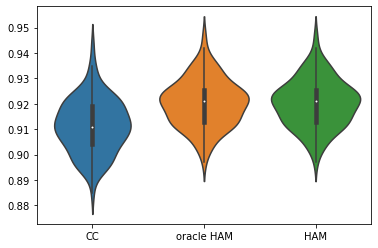

In [8]:
'''
EXAMPLE 1 - without missingness
'''

N_train = 1000


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.zeros((N_train,d))   
Y_train = np.zeros(N_train) 
O_train = np.ones((N_train,d))
for i in range(N_train):
    Y_train[i] = np.random.randint(2)   
    X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)  

# Generate Test Points
x_test = np.zeros((N_test,d))
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.randint(2)
    x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 

# Complete Case kNN
start = time.time()
accuracy_cc_kNN = 0
for i in range(N_test):
    if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_train,Y_train,O_train):
        accuracy_cc_kNN += 1/N_test
end = time.time()
run_time_cc_kNN = end-start
print('Runtime Complete Case kNN (in s): ',np.round(run_time_cc_kNN,3))
print('    Accuracy: ',np.round(accuracy_cc_kNN,3))

# Oracle HAM
start = time.time()
Omega_star = []
Omega_star.append(np.array([1,0],dtype="int"))
accuracy_oracle_HAM = 0
for i in range(N_test):
    if y_test[i] == HAM_classifier(x_test[i,:], Omega_star, X_train, Y_train, O_train):
        accuracy_oracle_HAM += 1/N_test
end = time.time()
run_time_oracle_HAM = end-start
print('Runtime Oracle HAM (in s): ',np.round(run_time_oracle_HAM,3))
print('    Accuracy: ',np.round(accuracy_oracle_HAM,3))

# Adaptive HAM
start = time.time()
Omega_hat = []
Omega_hat = estimate_Omega_star(X_train, Y_train, O_train)
accuracy_HAM = 0
for i in range(N_test):
    if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train):
        accuracy_HAM += 1/N_test
end = time.time()
run_time_HAM = end-start
print('Runtime HAM (in s): ',np.round(run_time_HAM,3))
print('    Accuracy: ',np.round(accuracy_HAM,3))


print('\nEstimated runtime (in min): ',np.round(iterations*(run_time_cc_kNN+run_time_HAM+run_time_oracle_HAM)/60,3))


''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.zeros((N_train,d))   
    Y_train = np.zeros(N_train) 
    O_train = np.ones((N_train,d))
    for i in range(N_train):
        Y_train[i] = np.random.randint(2)   
        X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)  

    # Generate Test Points
    x_test = np.zeros((N_test,d))
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.randint(2)
        x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 
        
    ''' Estimate Test Errors ''' 
    # Complete Case kNN
    for i in range(N_test):
        if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_train,Y_train,O_train):
            accuracy_cc_kNN[it] += 1/N_test

    # Oracle HAM
    for i in range(N_test):
        if y_test[i] == HAM_classifier(x_test[i,:], Omega_star, X_train, Y_train, O_train):
            accuracy_oracle_HAM[it] += 1/N_test

    # HAM
    Omega_hat = []
    Omega_hat = estimate_Omega_star(X_train, Y_train, O_train)
    for i in range(N_test):
        if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train):
            accuracy_HAM[it] += 1/N_test
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_oracle_HAM,accuracy_HAM]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','oracle HAM','HAM'])

plt.show(summary_plot)

In [9]:
''' Save accuracies for further use '''

np.save('Ex1_no_missingness_all_accuracies_cc_kNN',accuracy_cc_kNN[0:100])
np.save('Ex1_no_missingness_all_accuracies_oracle_HAM',accuracy_oracle_HAM[0:100])
np.save('Ex1_no_missingness_all_accuracies_HAM',accuracy_HAM[0:100])
np.save('Ex1_no_missingness_Bayes_risk',Bayes_risk)